## Simmulator

In [1]:
from qiskit import Aer

simulator_backend = Aer.get_backend("aer_simulator")

In [2]:
PRECISION = 3

In [3]:
from qiskit.circuit.library import SGate, ZGate

# get unitary matrix representation of S gate
U_matrix = SGate().to_matrix()
print(U_matrix)

[[1.+0.j 0.+0.j]
 [0.+0.j 0.+1.j]]


In [4]:
# create a list of matrices of U, U^2, U^4, U^8, ...
U_power = U_matrix
U_power_list = [U_power]
for _ in range(1, PRECISION):
  U_power = U_power @ U_power
  U_power_list.append(U_power)

In [5]:
U_power_list[2]

array([[1.+0.j, 0.+0.j],
       [0.+0.j, 1.+0.j]])

In [6]:
from qiskit.extensions import UnitaryGate

# create a list of controlled gates of U, U^2, U^4, U^8, ...
U_gate_list = [
  UnitaryGate(m, label=f'U^{2**i}').control() 
  for i, m in enumerate(U_power_list)
]

In [7]:
from qiskit.circuit.library import QFT

# get IQFT circuit
iqft_circuit = QFT(PRECISION, inverse=True)

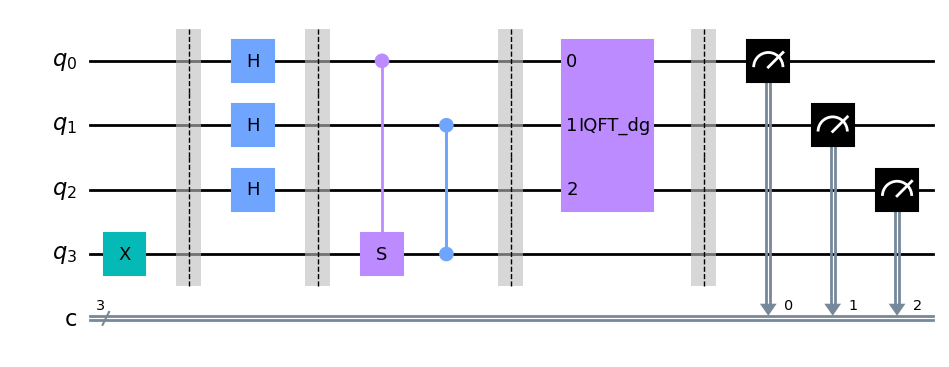

In [8]:
from qiskit import QuantumCircuit

# Create QPE circuit:
ancilla = list(range(PRECISION))
eigenstate = PRECISION

qc = QuantumCircuit(PRECISION + 1, PRECISION)
qc.x(eigenstate)  # v = \ket{1}
qc.barrier()
qc.h(ancilla)
qc.barrier()
qc.append(SGate().control(), [0, eigenstate])
qc.append(ZGate().control(), [1, eigenstate])
qc.barrier()
qc.compose(iqft_circuit, ancilla, inplace=True)
qc.barrier()
qc.measure(ancilla, ancilla)

qc.draw('mpl')

In [9]:
from qiskit import transpile

# Create a Qobj from the circuit for the simulator to run
test = transpile(qc, simulator_backend)

In [10]:
# Run the circuit on IonQ's platform:
job = simulator_backend.run(test, shots=1000).result()

# Print the counts
print(job.get_counts())

{'010': 1000}


## QPU

In [11]:
from qiskit_ionq import IonQProvider
provider = IonQProvider("your_private_token")

In [12]:
# Show all backends:
print(provider.backends())

[<IonQSimulatorBackend('ionq_simulator')>, <IonQQPUBackend('ionq_qpu')>]


In [13]:
qpu_backend = provider.get_backend("ionq_qpu")

In [14]:
transpiled_qc = transpile(qc, qpu_backend)

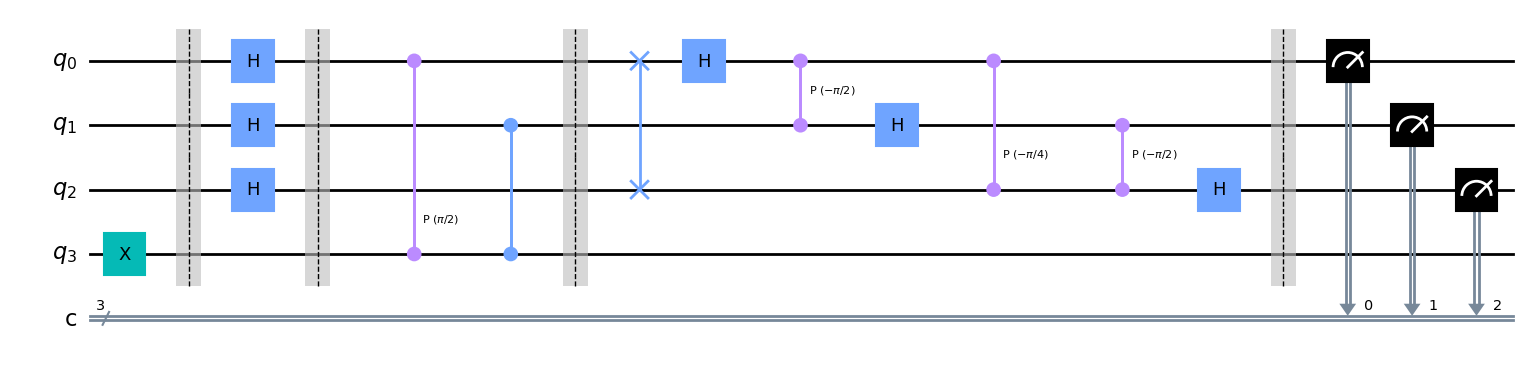

In [15]:
transpiled_qc.draw('mpl')

In [16]:
qpu_job = qpu_backend.run(transpiled_qc)

In [17]:
from qiskit.providers.jobstatus import JobStatus
import time
# Check if job is done
while qpu_job.status() is not JobStatus.DONE:
	print("Job status is", qpu_job.status() )
	time.sleep(60)

# grab a coffee! This can take up to a few minutes.
# once we break out of that while loop, we know our job is finished
print("Job status is", qpu_job.status() )
print(qpu_job.get_counts()) # these counts are the “true” counts from the actual QPU Run

Job status is JobStatus.INITIALIZING
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Job status is JobStatus.QUEUED
Jo

QPU Output
```
{'000': 62, '001': 20, '010': 769, '011': 27, '100': 51, '101': 10, '110': 53, '111': 32}
```